In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as Keras
from keras.applications import ResNet50

from sklearn import metrics
from scipy.spatial import distance

import json
import time

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
sys.path.append('/home/albert/github/tensorflow/')
import densenet
import triplet

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

In [5]:
print train_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_train/0575_c6s2_004068_01.jpg', 575]


In [6]:
print test_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_test/0152_c2s1_024601_02.jpg', 152]


### Train Network

In [7]:
# Number of identities
P_param = 8
# Number of images per identity
K_param = 4

In [8]:
def makeGaussian(shape, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, np.array(shape).max(), 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)[0:shape[0], 0:shape[1]]

In [9]:
def overlay_keypoints(img_path, train=False):
    if img_path.find('/') > -1:
        root = img_path[len(img_path) - img_path[::-1].index('/'):-4:]
    else:
        root = img_path[0:img_path.index('.')]
    
    img = misc.imread(img_path)
    htmp = np.zeros((128,64)).astype(np.float32)
    
    if train:
        keypoint_path = CAFFE_ROOT + \
                    'data/market-1501/train_openpose/train_keypoints/%s_keypoints.json' % root
    else:
        keypoint_path = CAFFE_ROOT + \
                    'data/market-1501/test_openpose/test_keypoints/%s_keypoints.json' % root
    with open(keypoint_path) as data_file:    
        data = json.load(data_file)
    for person in range(len(data['people'])):
        for i in range(0, len(data['people'][person]['pose_keypoints']), 3):
            x_key = data['people'][person]['pose_keypoints'][i]
            y_key = data['people'][person]['pose_keypoints'][i + 1]
            c_key = data['people'][person]['pose_keypoints'][i + 2]
            if not (x_key == 0 and y_key == 0):
                htmp += makeGaussian((128,64), fwhm=10, center=(x_key, y_key))

    if htmp.max() > 0.0:
        htmp = np.array([[3*[j/htmp.max()] for j in row] for row in htmp.tolist()])
    else:
        htmp = np.array([[3*[j] for j in row] for row in htmp.tolist()])
    return (img*htmp).astype(np.uint8)

In [10]:
def output_batch_generator(files_dict, labels, P=P_param, K=K_param):
    while True:
        batch_b = []
        batch_k = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            if K > len(files_dict[idt_choice[p]]):
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=True)
            else:
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=False)            
#             print k_choice, p
            for k in k_choice:
                img_path = files_dict[idt_choice[p]][k]
                img = misc.imread(img_path).astype(np.float64)
                batch_b.append(img.tolist())
                batch_k.append(overlay_keypoints(img_path, train=True).tolist())
        yield {'input_1_b' : np.array(batch_b, dtype=np.uint8), 'input_1_k' : np.array(batch_k, dtype=np.uint8)}, \
                {'final_output' : np.zeros((P*K, 128))}

In [11]:
start = time.time()
train_batch = output_batch_generator(train_dict, train_labels).next()
print time.time() - start

2.65119981766


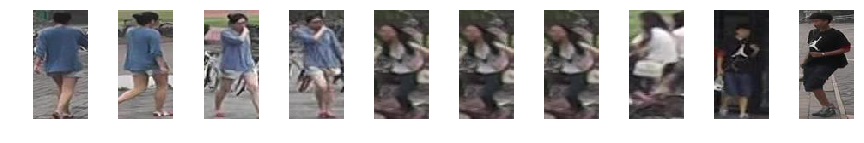

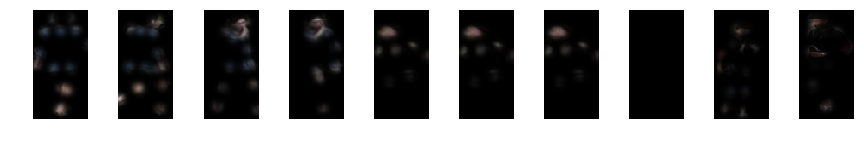

In [12]:
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_batch[0]['input_1_b'][i])
    plt.axis('off')
plt.show()
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_batch[0]['input_1_k'][i])
    plt.axis('off')
plt.show()

In [23]:
def evaluate_rank(net, rank, all_embeddings, all_identities, files_arr, test_iter=1000, shape=(128,64), train=False):
    correct = 0
    f_choice = np.random.choice(range(len(files_arr)), np.minimum(test_iter, len(files_arr)), replace=False)
    for f in f_choice:
        query_path = files_arr[f][0]
        query_img = misc.imread(query_path)
        query_embedding = net.predict({'input_1_b' : query_img.reshape(1, shape[0], shape[1], 3), 
                                       'input_1_k' : overlay_keypoints(query_path, train=train).reshape(1, shape[0], shape[1], 3)})
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
        i = 0
        for c in output_classes:
            if c == int(files_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
    return float(correct)/test_iter

In [14]:
def pos_pair_generator(files_dict):
    while True:
        idt = np.random.choice(files_dict.keys(), 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(files_dict[idt])), np.minimum(2, len(files_dict[idt])), replace=False)
        pair = [files_dict[idt][p] for p in sample_choice]
        yield pair

In [15]:
def neg_pair_generator(files_dict):
    while True:
        idt_choice = np.random.choice(files_dict.keys(), 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(files_dict[idt])), 1, replace=False)[0]
            pair.append(files_dict[idt][sample])
        yield pair

In [16]:
def evaluate_dist(model, generator, n_pairs=1000, train=False):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict({'input_1_b' : misc.imread(pair[i]).reshape(1,128,64,3), 
                                  'input_1_k' : overlay_keypoints(pair[i], train=train).reshape(1,128,64,3)}) for i in range(2)]
        dist = distance.cosine(predict[0], predict[1])
        distances.append(dist)
    return distances

In [17]:
# https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
model = load_model('/home/albert/github/tensorflow/models/densenet_triplet_merge/densenet_triplet_merge_1000.h5',
                        custom_objects={'triplet_loss':triplet.triplet_loss})

In [26]:
score = {
    'rank1' : {},
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

In [21]:
epochs = 10
steps_per_epoch = 100

file_root = 'densenet_triplet_merge'

iterations = 1000
    
all_embeddings = []
all_identities = []
z = 1
start = time.time()
for idt in test_dict.keys():
    for f in test_dict[idt]:
        img = misc.imread(f)
        predict = model.predict({'input_1_b' : img.reshape(1, 128, 64, 3), 
                                 'input_1_k' : overlay_keypoints(f, train=False).reshape(1, 128, 64, 3)})
#         print predict
        all_embeddings.append(predict)
        all_identities.append(idt)
        if z % 1000 == 0:
            print z, time.time() - start
        z += 1

1000 83.3863298893
2000 166.847445965
3000 250.823038101
4000 334.00761199
5000 420.314831018
6000 505.476932049
7000 590.766341925
8000 676.333410978
9000 762.442246914
10000 848.195297003
11000 932.597493887
12000 1017.58382297
13000 1104.3956151


In [27]:
for rank in [1,5,20]:
    rank_arr = []
    for x in range(3):
        rank_score = evaluate_rank(model, rank, all_embeddings, 
                                   all_identities, test_files, test_iter=1000)
        rank_arr.append(rank_score)
    score['rank%d' % rank][iterations] = rank_arr

pos_generator = pos_pair_generator(test_dict)
neg_generator = neg_pair_generator(test_dict)

pos_distance = evaluate_dist(model, pos_generator, train=False)
score['pos_distance'][iterations] = pos_distance
neg_distance = evaluate_dist(model, neg_generator, train=False)
score['neg_distance'][iterations] = neg_distance

score['precision'][iterations] = []
score['recall'][iterations] = []
score['matt_coef'][iterations] = []

for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
    true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
    pred_pos = [int(d < thresh) for d in pos_distance]
    pred_neg = [int(d < thresh) for d in neg_distance]
    pred = pred_pos + pred_neg

    score['precision'][iterations].append(metrics.precision_score(true, pred))
    score['recall'][iterations].append(metrics.recall_score(true, pred))
    score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))

file_name = file_root + '_' + str(iterations) + '.h5'
score['file_name'][iterations] = file_name

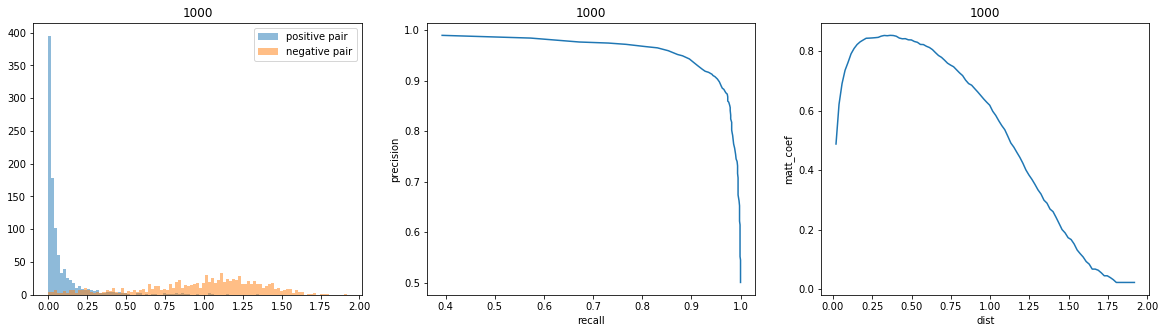

rank1 [0.627, 0.63, 0.628]
rank5 [0.868, 0.854, 0.845]
rank20 [0.949, 0.941, 0.951]


In [28]:
for score in [score]:
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance'][iterations]
    neg_distance = score['neg_distance'][iterations]
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')
    plt.title(str(iterations))

    plt.subplot(1,3,2)
    plt.plot(score['recall'][iterations], score['precision'][iterations])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(str(iterations))

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'][iterations])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    plt.title(str(iterations))
    plt.show()

    print 'rank1', score['rank1'][iterations]
    print 'rank5', score['rank5'][iterations]
    print 'rank20', score['rank20'][iterations]

In [49]:
print train_score['pos']

{1000: [0.784, 0.754, 0.775]}


In [ ]:
# summarize history for loss
plt.plot(score['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

for iterations in train_score['rank5'].keys():
    train_rank1_avg.append(np.average(np.array(train_score['rank1'][iterations])))
    train_rank5_avg.append(np.average(np.array(train_score['rank5'][iterations])))
    train_rank20_avg.append(np.average(np.array(train_score['rank20'][iterations])))
    test_rank1_avg.append(np.average(np.array(test_score['rank1'][iterations])))
    test_rank5_avg.append(np.average(np.array(test_score['rank5'][iterations])))
    test_rank20_avg.append(np.average(np.array(test_score['rank20'][iterations])))

In [ ]:
iterations = 6000
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(-0.5,0.9)
plt.show()

In [29]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score_2.npz' % (file_root, file_root), score)
# np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)